In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploratory data analysis

In [1]:
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from evoscaper.utils.visualise import create_network_inset, make_nx_weights
from evoscaper.utils.preprocess import make_datetime_str
import numpy as np
import itertools

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import plotly.express as px

SEED = 0
np.random.seed(SEED)

sns.set_style("whitegrid")

2025-03-28 11:15:45.916418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743160545.941173 3413603 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743160545.959568 3413603 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
top_write_dir = os.path.join('data', '09_motifs', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)


In [3]:
# fn = '../data/raw/summarise_simulation/2024_11_21_144918/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv'
fn_sim = './data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json'
# fn_sim = 'data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json'
fn = './data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json'

# fn_test_data = '../data/raw/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
# data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
data = pd.read_json(fn) if fn.endswith('.json') else pd.read_csv(fn)
data_sim = pd.read_json(fn_sim) if fn_sim.endswith('.json') else pd.read_csv(fn_sim)
len(data), len(data_sim)

(2579790, 3000000)

# Motifs

In [4]:
data['Log sensitivity'] = np.log10(data['sensitivity'])
data['Log precision'] = np.log10(data['precision'])
data_sim['overshoot/initial'] = data_sim['overshoot'] / \
    data_sim['initial_steady_states']
data_sim['overshoot/initial_bin'] = pd.cut(
    data_sim['overshoot/initial'], bins=10)
data_sim['overshoot/initial_bins'] = data_sim['overshoot/initial_bin'].apply(
    lambda x: np.round(x.mid, 2)).astype(np.float32)

n_species = 3
idx_species_in = 0
idx_species_out = 2
tri = list(zip(*[c.tolist() for c in np.triu_indices(n_species)]))
cols_e = get_true_interaction_cols(data, 'energies', remove_symmetrical=True)
n_interactions = len(cols_e)

In [5]:
# categories_motifs = ['conn_in_out', 'disconn_out', 'self_in', 'self_out', 'disconn_in']

# def conn_in_out(energies, idx_in, idx_out):
#     return energies[tri.index((idx_in, idx_out))] != 0

# def disconn_out(energies, idx_out):
#     idx_ins = jnp.arange(n_species)
#     idx_ins = idx_ins[idx_ins != idx_out].tolist()  # exclude self-connection
#     return jnp.sum(jnp.array([energies[tri.index(tuple(sorted((idx_in, idx_out))))] == 0 for idx_in in idx_ins]))

# def self_loop(energies, idx):
#     return energies[tri.index((idx, idx))] != 0


# data_sim['conn_in_out'] = jax.vmap(partial(
#     conn_in_out, idx_in=idx_species_in, idx_out=idx_species_out))(data_sim[cols_e].to_numpy())
# data_sim['disconn_out'] = jax.vmap(
#     partial(disconn_out, idx_out=idx_species_out))(data_sim[cols_e].to_numpy()) == (n_species - 1)
# data_sim['disconn_in'] = jax.vmap(
#     partial(disconn_out, idx_out=idx_species_out))(data_sim[cols_e].to_numpy()) == (n_species - 1)
# data_sim['self_in'] = jax.vmap(partial(self_loop, idx=idx_species_in))(
#     data_sim[cols_e].to_numpy())
# data_sim['self_out'] = jax.vmap(partial(self_loop, idx=idx_species_out))(
#     data_sim[cols_e].to_numpy())

# fig, axs = plt.subplots(1, len(categories_motifs), figsize=(4*len(categories_motifs), 4))
# for i, c in enumerate(categories_motifs):
#     sns.histplot(data_sim[filt], x='Log sensitivity', hue=c, bins=50, element='step', ax=axs[i])
#     axs[i].set_title(c)
# plt.tight_layout()

# figs, axs = plt.subplots(1, len(categories_motifs), figsize=(4*len(categories_motifs), 4))
# for i, c in enumerate(categories_motifs):
#     sns.histplot(data_sim, x='Log sensitivity', hue=c, bins=50, element='step', ax=axs[i])

In [6]:
data_sim['motif_cat'] = list(map(tuple, (data_sim[cols_e].to_numpy() != 0).astype(int).tolist()))

thresh_interaction = -5
data_sim['motif_cat_thresh'] = list(map(tuple, (data_sim[cols_e].to_numpy() < thresh_interaction).astype(int).tolist()))
thresh_interaction2 = -8
data_sim['motif_cat_thresh2'] = list(map(tuple, (data_sim[cols_e].to_numpy() < thresh_interaction2).astype(int).tolist()))

In [7]:
filt_adapt = (data_sim['Log precision'] > 1) & (data_sim['Log sensitivity'] > 0) & (data_sim['overshoot/initial'] > 0.05)
filt_valid = (data_sim['response_time'] < (0.8*data_sim['response_time'].max()))
filt_samp = data_sim['sample_name'] == 'RNA_2'
filt = filt_samp & filt_valid & filt_adapt
thresh_interaction2 = -8
data_sim['motif_cat_thresh2'] = list(map(tuple, (data_sim[cols_e].to_numpy() < thresh_interaction2).astype(int).tolist()))
print('motif_cat', len(data_sim['motif_cat'].unique()))
print('motif_cat_thresh', len(data_sim['motif_cat_thresh'].unique()))
print('motif_cat_thresh2', len(data_sim['motif_cat_thresh2'].unique()))
print('Adapt motif_cat', len(data_sim[filt]['motif_cat'].unique()))
print('Adapt motif_cat_thresh', len(data_sim[filt]['motif_cat_thresh'].unique()))
print('Adapt motif_cat_thresh2', len(data_sim[filt]['motif_cat_thresh2'].unique()))

motif_cat 64
motif_cat_thresh 64
motif_cat_thresh2 64
Adapt motif_cat 19
Adapt motif_cat_thresh 23
Adapt motif_cat_thresh2 20


/tmp/ipykernel_3413603/459866375.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data_sim.sort_values('motif_cat')[filt], x='Log sensitivity', y='Log precision', hue='motif_cat', bins=200, element='step', legend=True, ax=axs[0])
/tmp/ipykernel_3413603/459866375.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(data_sim.sort_values('motif_cat_thresh')[filt], x='Log sensitivity', y='Log precision', hue='motif_cat_thresh', bins=200, element='step', legend=True, ax=axs[1])


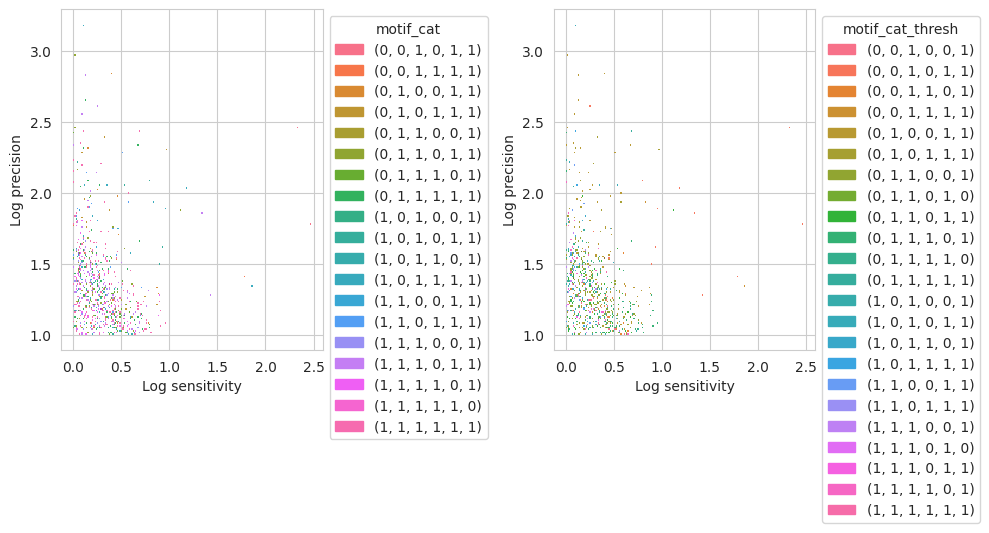

In [8]:
n = 2
fig, axs = plt.subplots(1, n, figsize=(5*n, 5))

sns.histplot(data_sim.sort_values('motif_cat')[filt], x='Log sensitivity', y='Log precision', hue='motif_cat', bins=200, element='step', legend=True, ax=axs[0])
sns.move_legend(axs[0], 'upper left', bbox_to_anchor=(1, 1))
sns.histplot(data_sim.sort_values('motif_cat_thresh')[filt], x='Log sensitivity', y='Log precision', hue='motif_cat_thresh', bins=200, element='step', legend=True, ax=axs[1])
sns.move_legend(axs[1], 'upper left', bbox_to_anchor=(1, 1))
# sns.histplot(data_sim.sort_values('motif_cat_thresh2')[filt], x='Log sensitivity', y='Log precision', hue='motif_cat_thresh2', bins=200, element='step', legend=True, ax=axs[2])
# sns.move_legend(axs[2], 'upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

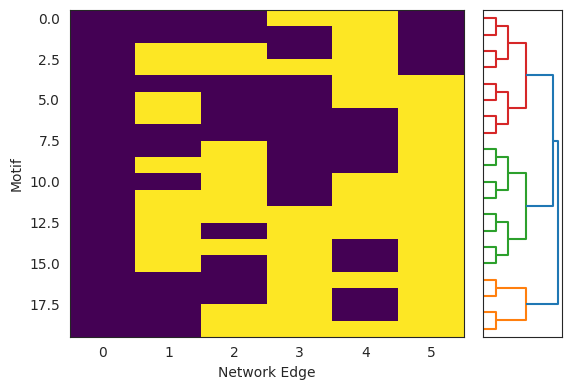

In [9]:
# np.array(data_sim[filt]['motif_cat'].unique())[:, tri.index((2, 2))]
sns.set_style('white')
motifs = data_sim[filt]['motif_cat_thresh2'].unique()
np.array([np.array(c) for c in motifs]) #[:, np.array([tri.index((0, 2)), tri.index((2, 2))])]

# Convert motifs to numpy array for clustering
motif_array = np.array([np.array(m) for m in motifs])

# Perform hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import leaves_list
from scipy.spatial.distance import pdist


# Calculate distance matrix and perform clustering
dist_matrix = pdist(motif_array, metric='hamming')
linkage_matrix = linkage(dist_matrix, method='ward')

# Create figure with heatmap and dendrogram
fig, ax = plt.subplots(figsize=(6, 4))

# Plot heatmap with hierarchical clustering
leaf_order = leaves_list(linkage_matrix)
clustered_motifs = motif_array[leaf_order]

im = ax.imshow(clustered_motifs, aspect='auto', cmap='viridis')
# plt.colorbar(im)

# Add dendrogram
ax_dendro = ax.inset_axes([1.05, 0, 0.2, 1])
dendrogram(linkage_matrix, orientation='right', ax=ax_dendro)
ax_dendro.set_xticks([])
ax_dendro.set_yticks([])

ax.set_xlabel('Network Edge')
ax.set_ylabel('Motif')
plt.tight_layout()



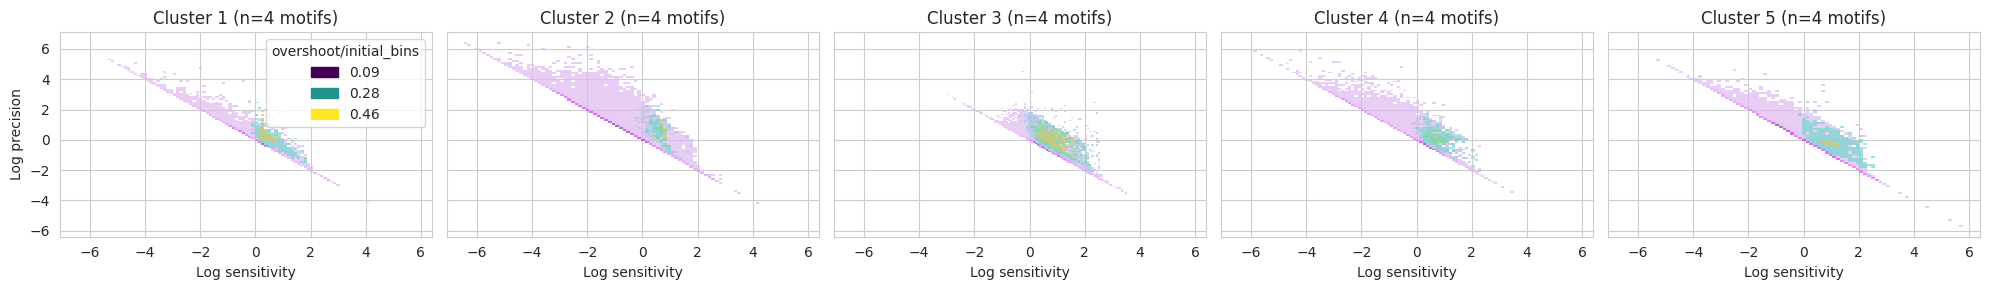

In [10]:

# Determine optimal number of clusters based on dendrogram
from scipy.cluster.hierarchy import fcluster
sns.set_style('whitegrid')
n_clusters = 5  # Based on visual inspection of dendrogram
n_largest_clusters = n_clusters
clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

def tuplise(arr):
    return [tuple(c) for c in arr]


# Get sizes of clusters
# Skip 0th element since clusters are 1-based
cluster_sizes = np.bincount(clusters)[1:]
# Get indices of 2 largest clusters
largest_clusters = np.argsort(cluster_sizes)[-n_largest_clusters:] #[::-1]

# Create figure to plot motifs from two largest clusters
fig, axs = plt.subplots(1, n_largest_clusters, figsize=(
    4*n_largest_clusters, 3), sharex=True, sharey=True)

for i, cluster_idx in enumerate(largest_clusters):
    # Get motifs belonging to this cluster
    cluster_mask = clusters == (cluster_idx + 1)
    cluster_motifs = motif_array[cluster_mask]

    # Plot motifs
    # im = axs[i].imshow(cluster_motifs, aspect='auto', cmap='RdBu')
    # axs[i].set_xlabel('Network Edge')
    # axs[i].set_ylabel('Motif')

    # sns.histplot(data_sim[filt][data_sim[filt]['motif_cat_thresh2'].isin([tuple(c) for c in cluster_motifs])], x='Log sensitivity', y='Log precision', ax=axs[i],
    sns.histplot(data_sim[filt_samp][data_sim[filt_samp]['motif_cat_thresh2'].isin(tuplise(cluster_motifs))], 
                 x='Log sensitivity', y='Log precision', ax=axs[i],
                 hue='overshoot/initial_bins',
                 # hue='initial_steady_states',
                 bins=80,
                 palette='viridis',
                 legend=True if i == 0 else False,
                 alpha=0.7)  # bins=100,
    
    axs[i].set_title(
        f'Cluster {cluster_idx + 1} (n={len(cluster_motifs)} motifs)')

# plt.colorbar(im, ax=axs)
plt.tight_layout()

In [11]:
# Cluster of most adaptive motifs

def tuplise(arr):
    return [tuple(c.tolist()) for c in arr]

idx_cluster_adapt = 3
cluster_mask = clusters == (idx_cluster_adapt + 1)
motifs_cluster_adapt = motif_array[cluster_mask]
print('Motifs in most adaptable cluster:')
motifs_cluster_adapt
# set([tuple(c.tolist()) for c in cluster_motifs]), set([tuple(c.tolist()) for c in motif_array]) - set([tuple(c.tolist()) for c in cluster_motifs])

Motifs in most adaptable cluster:


array([[0, 1, 1, 1, 1, 1],
       [0, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 1],
       [0, 1, 0, 1, 0, 1]])

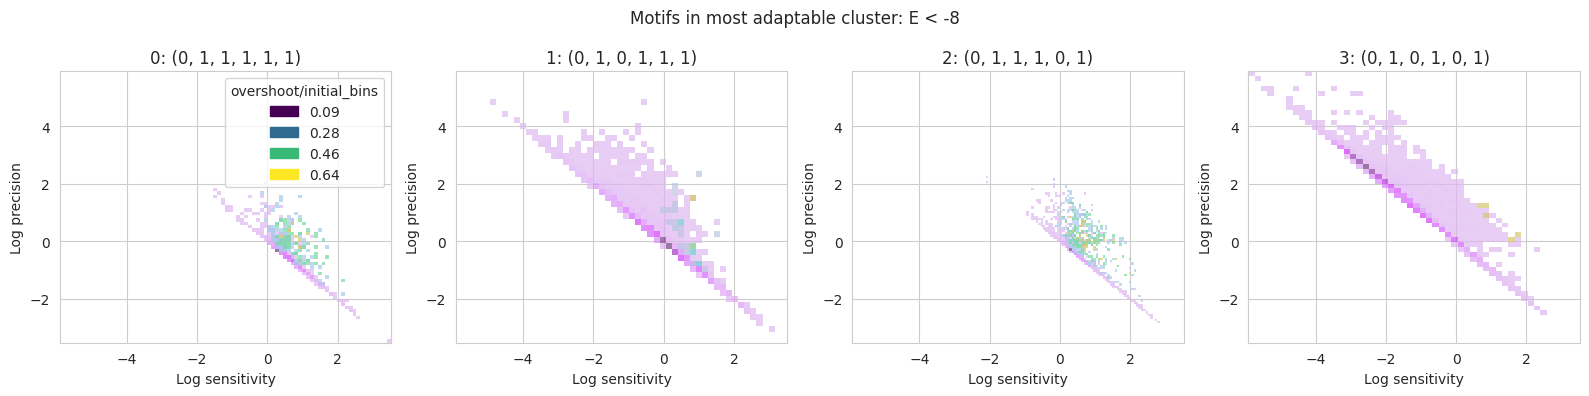

In [12]:
fig, axs = plt.subplots(1, len(motifs_cluster_adapt), figsize=(4*len(motifs_cluster_adapt), 4))
# vmin = data_sim[filt_samp][data_sim[filt_samp]['motif_cat_thresh2'].isin(tuplise(motifs_cluster_adapt))]['overshoot/initial_bins'].min()
# vmax = data_sim[filt_samp][data_sim[filt_samp]['motif_cat_thresh2'].isin(tuplise(motifs_cluster_adapt))]['overshoot/initial_bins'].max()
for i, m in enumerate(tuplise(motifs_cluster_adapt)):
    
    sns.histplot(data_sim[filt_samp][data_sim[filt_samp]['motif_cat_thresh2'] == m], x='Log sensitivity', y='Log precision', ax=axs[i],
                 hue='overshoot/initial_bins',
                 palette='viridis',
                 legend=True if i == 0 else False,
                 alpha=0.7)  # bins=100,
    axs[i].set_title(f'{i}: {m}')
    ii = data_sim[filt_samp][data_sim[filt_samp]['motif_cat_thresh2'].isin(tuplise(motifs_cluster_adapt))]['Log sensitivity']
    axs[i].set_xlim([ii.min(), ii.max()])
    ii = data_sim[filt_samp][data_sim[filt_samp]['motif_cat_thresh2'].isin(tuplise(motifs_cluster_adapt))]['Log precision']
    axs[i].set_ylim([ii.min(), ii.max()])
    # Get min and max values for consistent colorbar range
    # axs[i].collections[0].set_clim(vmin=vmin, vmax=vmax)
plt.suptitle(f'Motifs in most adaptable cluster: E < {thresh_interaction2}')
plt.tight_layout()

# TSNE

In [13]:
from sklearn.manifold import TSNE

# Run TSNE on interaction energies
SEED = 0
n_show = 5000
idxs_show = np.random.choice(len(data_sim[filt_samp]), n_show, replace=False)
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
tsne_result = tsne.fit_transform(data_sim[filt_samp][cols_e].values[idxs_show])


In [14]:
len(data_sim[filt_samp])

1000000

In [15]:
np.repeat(tsne_result[:, 0], repeats=data_sim['sample_name'].nunique())[:10]

array([-30.301727 , -30.301727 , -30.301727 ,   5.0472274,   5.0472274,
         5.0472274, -10.575493 , -10.575493 , -10.575493 ,  59.396034 ],
      dtype=float32)

/tmp/ipykernel_3413603/2365849748.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


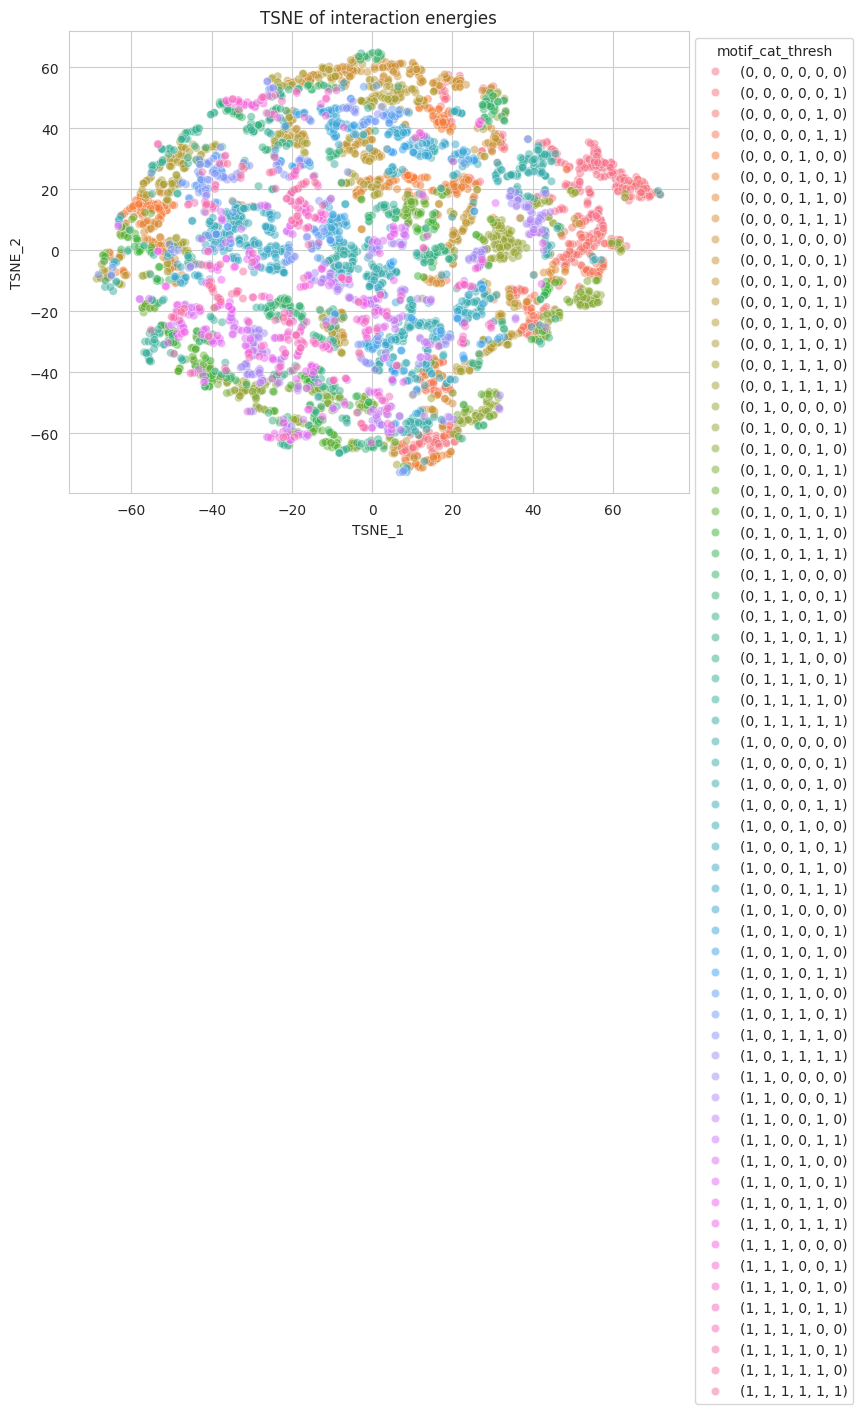

In [16]:
# Add TSNE results to dataframe
df_vis = pd.DataFrame()
df_vis['motif_cat_thresh2'] = data_sim[filt_samp]['motif_cat_thresh2'].values[idxs_show]
df_vis['motif_cat_thresh'] = data_sim[filt_samp]['motif_cat_thresh'].values[idxs_show]
df_vis['TSNE_1'] = tsne_result[:, 0]  # np.repeat(tsne_result[:, 0], repeats=data_sim['sample_name'].dropna().nunique())
df_vis['TSNE_2'] = tsne_result[:, 1]  # np.repeat(tsne_result[:, 1], repeats=data_sim['sample_name'].dropna().nunique())

# Plot TSNE results
plt.figure(figsize=(8, 6))
df_vis.sort_values('motif_cat_thresh', inplace=True)
g = sns.scatterplot(df_vis, x='TSNE_1', y='TSNE_2', hue='motif_cat_thresh', alpha=0.5)
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
plt.xlabel('TSNE_1')
plt.ylabel('TSNE_2')
plt.title('TSNE of interaction energies')
plt.tight_layout()



# Adaptation

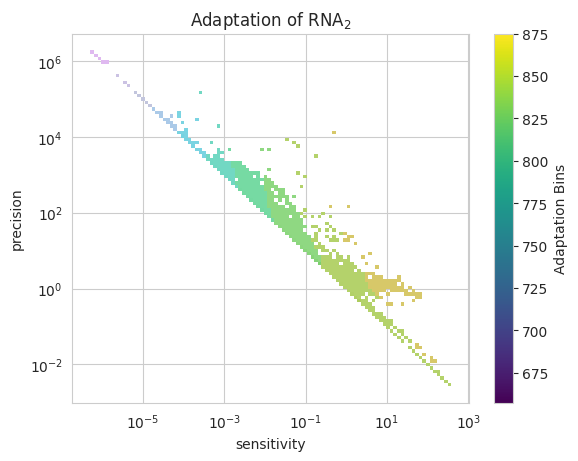

In [28]:
from evoscaper.utils.preprocess import format_with_subscript
filt = data['sample_name'] == 'RNA_2'
data['adaptation'] = calculate_adaptation(data['sensitivity'].to_numpy(), data['precision'].to_numpy(), alpha=2)
data['adaptation_bin'] = pd.cut(data['adaptation'], bins=10)
data['adaptation_bins'] = data['adaptation_bin'].apply(lambda x: np.round(x.mid, 1)).astype(float)
data['response_time_bin'] = pd.cut(data['response_time'], bins=10)
data['response_time_bins'] = data['response_time_bin'].apply(lambda x: x.mid).astype(float)
ax = plt.subplot(1,1,1)
g = sns.histplot(data[filt], x='sensitivity', y='precision', hue='adaptation_bins', 
                 log_scale=(True, True),
                 palette='viridis', bins=100, legend=False,
                 ax=ax)
# sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
ax.set_title(f'Adaptation of {format_with_subscript("RNA_2")}')
ax.hlines(1, np.nanmin(data['Log sensitivity']), np.nanmax(data['Log sensitivity']), color='r', linestyle='--')
ax.vlines(10, np.nanmin(data['Log precision']), np.nanmax(data['Log precision']), color='r', linestyle='--')

norm = plt.Normalize(vmin=data['adaptation_bins'].min(), vmax=data['adaptation_bins'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=g, label='Adaptation Bins')

plt.savefig(os.path.join(top_write_dir, 'adaptation.png'), dpi=300, bbox_inches='tight', transparent=True)

# Clustering

In [ ]:
exclude_cols = ['RMSE', 'num_interacting', 'num_self_interacting', 'circuit_name']
numerical_columns = data[data.columns.difference(exclude_cols)].select_dtypes(include=[np.number]).columns.tolist()
len(numerical_columns)

41

In [ ]:
data['Log sensitivity bin'] = pd.cut(data['Log sensitivity'], bins=10)
data['Log sensitivity bin'] = data['Log sensitivity bin'].apply(lambda x: np.round(x.mid, 1)).astype(float)

cols_e = get_true_interaction_cols(data, 'energies', remove_symmetrical=True)
combos_e = list(itertools.combinations(cols_e, 2))


In [ ]:
cols_e_bins = [f'{c} bin' for c in cols_e]
n_bins_energy = int(np.ceil(np.nanmax(np.abs(data[cols_e]))))
d = data[cols_e].melt(value_vars=cols_e, value_name='interaction_energy', var_name='interaction')
d['interaction_energy_bin'] = pd.cut(d['interaction_energy'], bins=n_bins_energy // 2).apply(lambda x: np.round(x.left, 2)).astype(float)
for c, c_bin in zip(cols_e, cols_e_bins):
    data[c_bin] = d[d['interaction'] == c]['interaction_energy_bin'].values
del d

In [ ]:
import hdbscan

def latin_hypercube_sampling(num_params, param_bounds, num_samples=1000):
    samples = np.zeros((num_samples, num_params))
    for i, (lower, upper) in enumerate(param_bounds):
        samples[:, i] = np.random.uniform(lower, upper, num_samples)
    
    # Shuffle to ensure stratified sampling
    for j in range(num_params):
        np.random.shuffle(samples[:, j])
    
    return samples

def reduce_dimensionality(df, n_components=2):
    X = df.values
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply UMAP
    reducer = umap.UMAP(n_components=n_components, random_state=SEED)
    X_reduced = reducer.fit_transform(X_scaled)
    
    # Add reduced coordinates to original DataFrame
    df['UMAP 1'] = X_reduced[:, 0]
    df['UMAP 2'] = X_reduced[:, 1]
    
    return df

def cluster_parameter_groups(df, eps=0.5, cols=['UMAP 1', 'UMAP 2'], min_cluster_size=5, min_samples=1, method='HDBSCAN'):
    if method == 'HDBSCAN':
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    else:
        clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    df['Cluster'] = clusterer.fit_predict(df[cols])
    return df


def visualize_results(df, hue='Cluster'):
    fig = px.scatter(
        df, 
        x='UMAP 1', 
        y='UMAP 2', 
        color=hue, 
        hover_data=[col for col in df.columns if col.startswith('param_')],
        title='Parameter Space Exploration'
    )
    # Set square dimensions and adjust layout
    fig.update_layout(
        width=600,  # Equal width and height
        height=600,
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(l=50, r=50, t=50, b=50)
    )
    return fig

# Create and run analysis
filt_d = (data['sample_name'] == 'RNA_2') & (data['Log sensitivity'] > -5) & (data['Log sensitivity'] < 3) & (~data['Log precision'].isna())
filt_d = filt_d & (data['Log sensitivity'] >= 1) & (data['Log precision'] >= 0)
# filt_d = filt_d & (data['adaptation'] > 870)
results = data[filt_d][cols_e_bins] # + ['Log sensitivity', 'Log precision']] #.iloc[:10000]
reduced_results = reduce_dimensionality(results)
n_neighbors = 1 # len(data[filt_d]) // 50
min_cluster_size = 5
clustered_results = cluster_parameter_groups(reduced_results, min_samples=n_neighbors, 
                                             min_cluster_size=min_cluster_size, method='HDBSCAN')
# visualization = visualize_results(clustered_results)
# visualization.show()
clustered_results[cols_e] = data[filt_d][cols_e]
len(data[filt_d]), n_neighbors

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(96, 1)

# Vis cluster + motifs

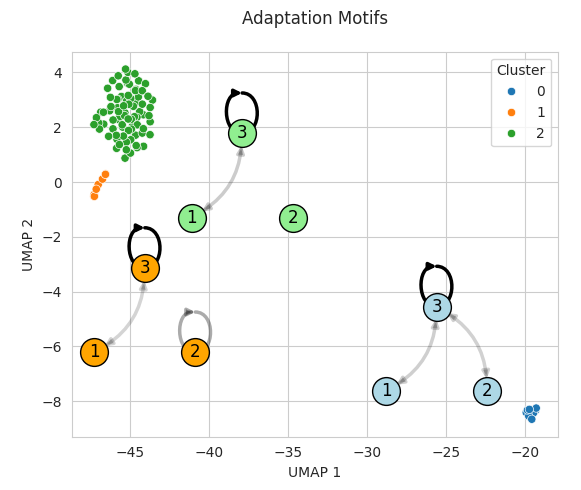

In [ ]:
# from evoscaper.utils.visualise import create_network_inset, make_nx_weights
fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(clustered_results, x='UMAP 1', y='UMAP 2',
                hue='Cluster', palette='tab10')
colors = ['lightblue', 'orange', 'lightgreen']
pos = [[0.4, -0.1], [-0.2, 0.0], [0, 0.35]]
for i, c in enumerate(sorted(clustered_results['Cluster'].unique())):
    fake_circuits = clustered_results[clustered_results['Cluster']
                                      == c][cols_e].values
    w = fake_circuits.mean(axis=0)
    create_network_inset(fig, ax,
                         pos=pos[i],
                         width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3), 
                         node_color=colors[i], linewidth=2.5)
plt.title('Adaptation Motifs')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'motifs.png'), dpi=300, bbox_inches='tight', transparent=True)

clustered_results.to_json(os.path.join(top_write_dir, 'clustered_results.json'), orient='records', lines=True)

In [ ]:
g = sns.barplot(clustered_results.melt(id_vars=['Cluster'], value_vars=cols_e, value_name='Energy', var_name='Interaction ID'),
                x='Cluster', y='Energy',
                hue='Interaction ID',
                palette='Spectral')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
plt.title('Clustered interaction energies')

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['cluster']"

In [ ]:
# for ic, cluster in enumerate(clustered_results['cluster'].unique()):
#     print(f'Cluster {ic}:')
#     print(clustered_results[clustered_results['cluster'] == cluster][cols_e].agg(['mean', 'std']))

In [ ]:
# clusters = sorted(clustered_results['cluster'].unique())
# nrows = len(clusters)
# ncols = len(cols_e)
# fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True, sharey=True)
# if nrows == 1:
#     axs = axs[np.newaxis, :]
# for ic, cluster in enumerate(clusters):
#     for i, e_col in enumerate(cols_e):
#         sns.scatterplot(clustered_results[clustered_results['cluster'] == cluster], x='UMAP_1', y='UMAP_2', 
#                         hue=e_col, palette='viridis', alpha=0.5, ax=axs[ic, i], legend=False)
#         if ic == 0:
#             plt.title(e_col)
#         if axs[ic, i].get_legend() is not None:
#             sns.move_legend(axs[ic, i], 'upper left', bbox_to_anchor=(1, 1))
#         if not (i < len(cols_e) - 1):
#             norm = plt.Normalize(np.nanmin(clustered_results[cols_e]), np.nanmax(clustered_results[cols_e]))
#             sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
#             sm.set_array([])
#             fig.colorbar(sm, ax=axs[ic, i], orientation='vertical', label='Energies')

In [ ]:
# clusters = sorted(clustered_results['cluster'].unique())
# nrows = int(np.ceil(np.sqrt(len(clusters))))
# ncols = int(np.ceil(np.sqrt(len(clusters))))
# fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
# for i, cluster in enumerate(clusters):
#     ax = axes.flatten()[i]
#     filt = clustered_results['cluster'] == cluster
#     sns.histplot(clustered_results[filt], x='Log sensitivity', y='Log precision', ax=ax)
#     ax.set_xlim(clustered_results['Log sensitivity'].min(), clustered_results['Log sensitivity'].max())
#     ax.set_ylim(clustered_results['Log precision'].min(), clustered_results['Log precision'].max())
#     ax.set_title(f'Cluster {cluster}')
# plt.tight_layout()

In [ ]:
# nrows = len(cols_e)
# cols = len(cols_e)
# fig, axes = plt.subplots(nrows, cols, figsize=(3*cols, 2*nrows))
# for i, (k1, k2) in enumerate(combos_e):
#     ax = axes[cols_e.index(k1), cols_e.index(k2)]
#     c_i = clustered_results[clustered_results['cluster'] == 14]
#     sns.histplot(c_i, x=k1, y=k2, hue='cluster', palette='viridis', ax=ax, legend=False if i < len(combos_e) - 1 else True, alpha=0.5)
#     if ax.get_legend() is not None:
#         sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()